# Example of loading a custom tree model into SHAP

This notebook shows how to pass a custom tree ensemble model into SHAP for explanation.

In [1]:
import numpy as np
import scipy
import shap
import sklearn
import graphviz

## Simple regression tree model

Here we define a simple regression tree and then load it into SHAP as a custom model.

In [2]:
X,y = shap.datasets.boston()

orig_model = sklearn.tree.DecisionTreeRegressor(max_depth=2)
orig_model.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

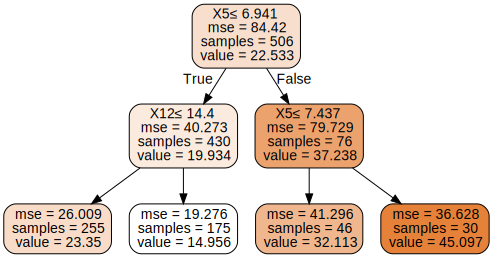

In [3]:
dot_data = sklearn.tree.export_graphviz(orig_model, out_file=None, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [4]:
# extract the arrays that define the tree
children_left = orig_model.tree_.children_left
children_right = orig_model.tree_.children_right
children_default = children_right.copy() # because sklearn does not use missing values
features = orig_model.tree_.feature
thresholds = orig_model.tree_.threshold
values = orig_model.tree_.value.reshape(orig_model.tree_.value.shape[0], 1)
node_sample_weight = orig_model.tree_.weighted_n_node_samples

print("     children_left", children_left) # note that negative children values mean this is a leaf node
print("    children_right", children_right)
print("  children_default", children_default)
print("          features", features)
print("        thresholds", thresholds.round(3))
print("            values", values.round(3))
print("node_sample_weight", node_sample_weight)

     children_left [ 1  2 -1 -1  5 -1 -1]
    children_right [ 4  3 -1 -1  6 -1 -1]
  children_default [ 4  3 -1 -1  6 -1 -1]
          features [ 5 12 -2 -2  5 -2 -2]
        thresholds [ 6.941 14.4   -2.    -2.     7.437 -2.    -2.   ]
            values [[22.533]
 [19.934]
 [23.35 ]
 [14.956]
 [37.238]
 [32.113]
 [45.097]]
node_sample_weight [506. 430. 255. 175.  76.  46.  30.]


In [5]:
# define a custom tree model
tree_dict = {
    "children_left": children_left,
    "children_right": children_right,
    "children_default": children_default,
    "features": features,
    "thresholds": thresholds,
    "values": values,
    "node_sample_weight": node_sample_weight
}
model = {
    "trees": [tree_dict]
}

In [6]:
explainer = shap.TreeExplainer(model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [7]:
# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
assert np.abs(explainer.model.predict(X) - orig_model.predict(X)).max() < 1e-4

In [8]:
# make sure the SHAP values sum up to the model output (this is the local accuracy property)
assert np.abs(explainer.expected_value + explainer.shap_values(X).sum(1) - orig_model.predict(X)).max() < 1e-4

## Simple GBM classification model (with 2 trees)

Here we define a simple regression tree and then load it into SHAP as a custom model.

In [9]:
X2,y2 = shap.datasets.adult()
orig_model2 = sklearn.ensemble.GradientBoostingClassifier(n_estimators=2)
orig_model2.fit(X2, y2)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=2,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Pull the info of the first tree

In [10]:
tree_tmp = orig_model2.estimators_[0][0].tree_

# extract the arrays that define the tree
children_left1 = tree_tmp.children_left
children_right1 = tree_tmp.children_right
children_default1 = children_right1.copy() # because sklearn does not use missing values
features1 = tree_tmp.feature
thresholds1 = tree_tmp.threshold
values1 = tree_tmp.value.reshape(tree_tmp.value.shape[0], 1)
node_sample_weight1 = tree_tmp.weighted_n_node_samples

print("     children_left1", children_left1) # note that negative children values mean this is a leaf node
print("    children_right1", children_right1)
print("  children_default1", children_default1)
print("          features1", features1)
print("        thresholds1", thresholds1.round(3))
print("            values1", values1.round(3))
print("node_sample_weight1", node_sample_weight1)

     children_left1 [ 1  2  3 -1 -1  6 -1 -1  9 10 -1 -1 13 -1 -1]
    children_right1 [ 8  5  4 -1 -1  7 -1 -1 12 11 -1 -1 14 -1 -1]
  children_default1 [ 8  5  4 -1 -1  7 -1 -1 12 11 -1 -1 14 -1 -1]
          features1 [ 5  8  2 -2 -2  0 -2 -2  2  8 -2 -2  8 -2 -2]
        thresholds1 [ 3.5000e+00  7.0735e+03  1.2500e+01 -2.0000e+00 -2.0000e+00  2.0500e+01
 -2.0000e+00 -2.0000e+00  1.2500e+01  5.0955e+03 -2.0000e+00 -2.0000e+00
  5.0955e+03 -2.0000e+00 -2.0000e+00]
            values1 [[-0.   ]
 [-0.175]
 [-0.191]
 [-1.177]
 [-0.503]
 [ 0.721]
 [-0.223]
 [ 4.013]
 [ 0.211]
 [ 0.094]
 [ 0.325]
 [ 4.048]
 [ 0.483]
 [ 2.372]
 [ 4.128]]
node_sample_weight1 [3.2561e+04 1.7800e+04 1.7482e+04 1.4036e+04 3.4460e+03 3.1800e+02
 5.0000e+00 3.1300e+02 1.4761e+04 1.0329e+04 9.8070e+03 5.2200e+02
 4.4320e+03 3.7540e+03 6.7800e+02]


### Pull the info of the second tree

In [11]:
tree_tmp = orig_model2.estimators_[1][0].tree_

# extract the arrays that define the tree
children_left2 = tree_tmp.children_left
children_right2 = tree_tmp.children_right
children_default2 = children_right2.copy() # because sklearn does not use missing values
features2 = tree_tmp.feature
thresholds2 = tree_tmp.threshold
values2 = tree_tmp.value.reshape(tree_tmp.value.shape[0], 1)
node_sample_weight2 = tree_tmp.weighted_n_node_samples

print("     children_left2", children_left2) # note that negative children values mean this is a leaf node
print("    children_right2", children_right2)
print("  children_default2", children_default2)
print("          features2", features2)
print("        thresholds2", thresholds2.round(3))
print("            values2", values2.round(3))
print("node_sample_weight2", node_sample_weight2)

     children_left2 [ 1  2  3 -1 -1  6 -1 -1  9 10 -1 -1 13 -1 -1]
    children_right2 [ 8  5  4 -1 -1  7 -1 -1 12 11 -1 -1 14 -1 -1]
  children_default2 [ 8  5  4 -1 -1  7 -1 -1 12 11 -1 -1 14 -1 -1]
          features2 [ 5  8  2 -2 -2  0 -2 -2  2  8 -2 -2  8 -2 -2]
        thresholds2 [ 3.5000e+00  7.0735e+03  1.3500e+01 -2.0000e+00 -2.0000e+00  2.0500e+01
 -2.0000e+00 -2.0000e+00  1.2500e+01  5.0955e+03 -2.0000e+00 -2.0000e+00
  5.0955e+03 -2.0000e+00 -2.0000e+00]
            values2 [[-1.000e-03]
 [-1.580e-01]
 [-1.720e-01]
 [-1.062e+00]
 [ 1.360e-01]
 [ 6.420e-01]
 [-2.030e-01]
 [ 2.993e+00]
 [ 1.880e-01]
 [ 8.400e-02]
 [ 2.870e-01]
 [ 3.015e+00]
 [ 4.310e-01]
 [ 1.895e+00]
 [ 3.066e+00]]
node_sample_weight2 [3.2561e+04 1.7800e+04 1.7482e+04 1.6560e+04 9.2200e+02 3.1800e+02
 5.0000e+00 3.1300e+02 1.4761e+04 1.0329e+04 9.8070e+03 5.2200e+02
 4.4320e+03 3.7540e+03 6.7800e+02]


### Create a list of SHAP Trees

In [12]:
# define a custom tree model
tree_dicts = [
    {
        "children_left": children_left1,
        "children_right": children_right1,
        "children_default": children_default1,
        "features": features1,
        "thresholds": thresholds1,
        "values": values1 * orig_model2.learning_rate,
        "node_sample_weight": node_sample_weight1
    },
    {
        "children_left": children_left2,
        "children_right": children_right2,
        "children_default": children_default2,
        "features": features2,
        "thresholds": thresholds2,
        "values": values2 * orig_model2.learning_rate,
        "node_sample_weight": node_sample_weight2
    },
]
model2 = {
    "trees": tree_dicts,
    "base_offset": scipy.special.logit(orig_model2.init_.class_prior_[1]),
    "tree_output": "log_odds",
    "objective": "binary_crossentropy",
    "input_dtype": np.float32, # this is what type the model uses the input feature data
    "internal_dtype": np.float64 # this is what type the model uses for values and thresholds
}


### Explain the custom model

In [13]:
# build a background dataset for us to use based on people near a 0.95 cutoff
vs = np.abs(orig_model2.predict_proba(X2)[:,1] - 0.95)
inds = np.argsort(vs)
inds = inds[:200]

In [14]:
# build an explainer that explains the probability output of the model
explainer2 = shap.TreeExplainer(model2, X2.iloc[inds,:], feature_dependence="independent", model_output="probability")

feature_dependence = "independent" has been renamed to feature_perturbation == "interventional"! See GitHub issue #882.


In [15]:
# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
assert np.abs(explainer2.model.predict(X2, output="probability") - orig_model2.predict_proba(X2)[:,1]).max() < 1e-4

In [16]:
# make sure the sum of the SHAP values equals the model output
shap_sum = explainer2.expected_value + explainer2.shap_values(X2.iloc[:,:]).sum(1)
assert np.abs(shap_sum - orig_model2.predict_proba(X2)[:,1]).max() < 1e-4